In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", legacy=False)

In [ ]:
import torch
import gc

if not torch.cuda.is_available():
    print("CUDA is not available. Please ensure you have a compatible GPU and drivers installed.")
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
from transformers import AutoModelForCausalLM

# Recarrega o modelo salvo
model = AutoModelForCausalLM.from_pretrained(
    './Llama-3.2-1b-Gather/').to('cpu')

# Verifica a estrutura do modelo recarregado
print(model)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at ./Llama-3.2-1b-Gather/ and are newly initialized: ['model.norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList()
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
)


In [3]:
def text_to_embedding(input_text):
    with torch.no_grad():
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to('cpu')
        embedding = model.model.embed_tokens(input_ids)  # [1,2048] até [1024,2048]
        embedding = embedding.cpu()  # Move para CPU
    return embedding[0]

In [2]:
import time
import logging
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)


class SequenceDataset_val(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # start_time = time.time()

        row = self.df.iloc[idx]
        sequence1 = text_to_embedding(row['content1'])
        sequence2 = text_to_embedding(row['content2'])

        # Use the transformed target
        target = torch.tensor(row['target_transformed'], dtype=torch.float32)

        # Convert sequences to tensors (no need to reconvert embedding)
        #sequence1 = sequence1.float()
        #sequence2 = sequence2.float()

        # end_time = time.time()
        # if idx % 1000 == 0:
        #    logger.info(f"Processing sample {idx}/{len(self.df)} - Time: {end_time - start_time:.4f}s")

        return sequence1, sequence2, target

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import duckdb
from tqdm import tqdm

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)

# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Subamostragem
def subamostrar_bin(df, bin_categoria, tamanho):
	return df[df['bin'] == bin_categoria].sample(n=tamanho, random_state=42)

class SequenceDataset(Dataset):
	def __init__(self):
		df_training = conn.execute(f"""
		-- Materialize o combined_dataset primeiro
		CREATE TEMPORARY TABLE temp_combined_dataset AS
		SELECT * FROM dataset
		UNION ALL
		SELECT * FROM {alias_db2}.dataset;

		-- Em seguida, use a tabela temporária nas amostragens
		WITH sampled_a AS (
			SELECT id, indice, content, name
			FROM (
				SELECT
					id,
					indice,
					content,
					name,
					ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
					COUNT(*) OVER (PARTITION BY name) AS total_count
				FROM temp_combined_dataset
			) sub
			WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
		),
		sampled_b AS (
			SELECT id, indice, content, name
			FROM (
				SELECT
					id,
					indice,
					content,
					name,
					ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
					COUNT(*) OVER (PARTITION BY name) AS total_count
				FROM temp_combined_dataset
			) sub
			WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
		)
		SELECT
			a.name AS name,
			a.content AS content1,
			b.content AS content2,
			SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
		FROM sampled_a a
		JOIN sampled_b b
			ON a.name = b.name
			-- AND a.id != b.id
		ORDER BY RANDOM()
		LIMIT 10000;
		""").df()

		# Binarização
		num_bins = 10
		df_training['bin'] = pd.cut(df_training['target_transformed'], bins=num_bins)

		# Frequência por bin
		frequencia = df_training['bin'].value_counts().sort_index()

		# Tamanho mínimo de amostra por bin
		min_freq = frequencia.min()

		df_uniforme = pd.concat([
			subamostrar_bin(df_training, bin_cat, min_freq) 
			for bin_cat in frequencia.index
		])

		df_uniforme = df_uniforme.reset_index(drop=True)
		df_uniforme = df_uniforme.drop('bin', axis=1)
		self.df = df_uniforme.reset_index(drop=True)
				
	def __len__(self):
		return 20000

	def __getitem__(self, idx):
		if idx % len(self.df) == 0:
			df_training = conn.execute(f"""
			-- Materialize o combined_dataset primeiro
			CREATE TEMPORARY TABLE temp_combined_dataset AS
			SELECT * FROM dataset
			UNION ALL
			SELECT * FROM {alias_db2}.dataset;

			-- Em seguida, use a tabela temporária nas amostragens
			WITH sampled_a AS (
				SELECT id, indice, content, name
				FROM (
					SELECT
						id,
						indice,
						content,
						name,
						ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
						COUNT(*) OVER (PARTITION BY name) AS total_count
					FROM temp_combined_dataset
				) sub
				WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
			),
			sampled_b AS (
				SELECT id, indice, content, name
				FROM (
					SELECT
						id,
						indice,
						content,
						name,
						ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
						COUNT(*) OVER (PARTITION BY name) AS total_count
					FROM temp_combined_dataset
				) sub
				WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
			)
			SELECT
				a.name AS name,
				a.content AS content1,
				b.content AS content2,
				SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
			FROM sampled_a a
			JOIN sampled_b b
				ON a.name = b.name
				-- AND a.id != b.id
			ORDER BY RANDOM()
			LIMIT 10000;
			""").df()

			# Binarização
			num_bins = 10
			df_training['bin'] = pd.cut(df_training['target_transformed'], bins=num_bins)

			# Frequência por bin
			frequencia = df_training['bin'].value_counts().sort_index()

			# Tamanho mínimo de amostra por bin
			min_freq = frequencia.min()

			df_uniforme = pd.concat([
				subamostrar_bin(df_training, bin_cat, min_freq) 
				for bin_cat in frequencia.index
			])

			df_uniforme = df_uniforme.reset_index(drop=True)
			self.df = df_uniforme.drop('bin', axis=1)

		print("idx",idx)
		row = self.df.iloc[idx%len(self.df)]
		sequence1 = text_to_embedding(row['content1'])
		sequence2 = text_to_embedding(row['content2'])

		# Use the transformed target
		target = torch.tensor(row['target_transformed'], dtype=torch.float32)

		return sequence1, sequence2, target

In [1]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import duckdb
from tqdm import tqdm
import pandas as pd

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

def subamostrar_bin(df, bin_categoria, tamanho):
    return df[df['bin'] == bin_categoria].sample(n=tamanho, random_state=42)

class InfiniteSequenceDataset(IterableDataset):
    def __init__(self, db1_path, db2_path, alias_db2, batch_size=10000, num_bins=10):
        super(InfiniteSequenceDataset, self).__init__()
        self.db1_path = db1_path
        self.db2_path = db2_path
        self.alias_db2 = alias_db2
        self.batch_size = batch_size
        self.num_bins = num_bins

    def _fetch_data(self, conn):
        query = f"""
        -- Materialize the combined_dataset first
        CREATE TEMPORARY TABLE temp_combined_dataset AS
        SELECT * FROM dataset
        UNION ALL
        SELECT * FROM {self.alias_db2}.dataset;

        -- Use the temporary table for sampling
        WITH sampled_a AS (
            SELECT id, indice, content, name
            FROM (
                SELECT
                    id,
                    indice,
                    content,
                    name,
                    ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
                    COUNT(*) OVER (PARTITION BY name) AS total_count
                FROM temp_combined_dataset
            ) sub
            WHERE rn <= CEIL(0.10 * total_count)  -- Adjust the rate as needed
        ),
        sampled_b AS (
            SELECT id, indice, content, name
            FROM (
                SELECT
                    id,
                    indice,
                    content,
                    name,
                    ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
                    COUNT(*) OVER (PARTITION BY name) AS total_count
                FROM temp_combined_dataset
            ) sub
            WHERE rn <= CEIL(0.10 * total_count)  -- Adjust the rate as needed
        )
        SELECT
            a.name AS name,
            a.content AS content1,
            b.content AS content2,
            SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
        FROM sampled_a a
        JOIN sampled_b b
            ON a.name = b.name
        ORDER BY RANDOM()
        LIMIT {self.batch_size};
        """
        df = conn.execute(query).df()

        # Binarização
        df['bin'] = pd.cut(df['target_transformed'], bins=self.num_bins)

        # Frequência por bin
        frequencia = df['bin'].value_counts().sort_index()

        # Tamanho mínimo de amostra por bin
        min_freq = frequencia.min()

        df_uniforme = pd.concat([
            subamostrar_bin(df, bin_cat, min_freq) 
            for bin_cat in frequencia.index
        ]).reset_index(drop=True)

        df_uniforme = df_uniforme.drop('bin', axis=1)
        return df_uniforme

    def __iter__(self):
        # Each worker will have its own connection
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # Single worker
            conn = duckdb.connect(database=self.db1_path, read_only=False)
            conn.execute(f"ATTACH DATABASE '{self.db2_path}' AS {self.alias_db2}")
            while True:
                df = self._fetch_data(conn)
                for _, row in df.iterrows():
                    sequence1 = text_to_embedding(row['content1'])
                    sequence2 = text_to_embedding(row['content2'])
                    target = torch.tensor(row['target_transformed'], dtype=torch.float32)
                    yield sequence1, sequence2, target
        else:
            # Multiple workers
            conn = duckdb.connect(database=self.db1_path, read_only=False)
            conn.execute(f"ATTACH DATABASE '{self.db2_path}' AS {self.alias_db2}")
            while True:
                df = self._fetch_data(conn)
                for _, row in df.iterrows():
                    sequence1 = text_to_embedding(row['content1'])
                    sequence2 = text_to_embedding(row['content2'])
                    target = torch.tensor(row['target_transformed'], dtype=torch.float32)
                    yield sequence1, sequence2, target

In [6]:
import numpy as np

def signed_log_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_signed_log_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

def dissimilaridade(S):
	epsilon = 0
	if S == 0:
		max_x = np.log(np.finfo(np.float32).max)
		epsilon = (1/(max_x-1))
        
	return (1 - (S+epsilon)) / (S+epsilon)

In [6]:
import duckdb
from tqdm import tqdm

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)

# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Executar a consulta modificada
df_training = conn.execute(f"""
-- Materialize o combined_dataset primeiro
CREATE TEMPORARY TABLE temp_combined_dataset AS
SELECT * FROM dataset
UNION ALL
SELECT * FROM {alias_db2}.dataset;

-- Em seguida, use a tabela temporária nas amostragens
WITH sampled_a AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
            COUNT(*) OVER (PARTITION BY name) AS total_count
        FROM temp_combined_dataset
    ) sub
    WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
),
sampled_b AS (
    SELECT id, indice, content, name
    FROM (
        SELECT
            id,
            indice,
            content,
            name,
            ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn,
            COUNT(*) OVER (PARTITION BY name) AS total_count
        FROM temp_combined_dataset
    ) sub
    WHERE rn <= CEIL(0.10 * total_count)  -- Ajuste a taxa conforme necessário
)
SELECT
    a.name AS name,
    a.content AS content1,
    b.content AS content2,
    SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
FROM sampled_a a
JOIN sampled_b b
    ON a.name = b.name
    -- AND a.id != b.id
ORDER BY RANDOM()
LIMIT 10000;
""").df()

df_training

BinderException: Binder Error: Unique file handle conflict: Database "db2_alias" is already attached with path "books.duckdb", 

In [1]:
import duckdb
from tqdm import tqdm

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)

# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Executar a consulta modificada
df_training = conn.execute(f"""
WITH temp_combined_dataset AS (
    SELECT * FROM dataset
    UNION ALL
    SELECT * FROM {alias_db2}.dataset
),
limited_sample AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
    FROM temp_combined_dataset
    WHERE RANDOM() < 0.5  -- Adjust the initial sampling rate as needed
),
sampled_data AS (
    SELECT *
    FROM limited_sample
    WHERE rn <= 10  -- Limit to 10 rows per 'name' (adjust as needed)
),
paired_data AS (
    SELECT
        a.name,
        a.content AS content1,
        b.content AS content2,
        ABS(a.indice - b.indice) AS indice_diff,
        SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
    FROM sampled_data a
    JOIN sampled_data b
        ON a.name = b.name 
		-- AND a.id < b.id  -- Avoid duplicates and self-pairs
),
binned_pairs AS (
    SELECT *,
        NTILE(10) OVER (ORDER BY indice_diff) AS bin
    FROM paired_data
),
final_sample AS (
    SELECT *
    FROM binned_pairs
    WHERE RANDOM() < 0.5  -- Adjust per-bin sampling rate as needed
)
SELECT *
FROM final_sample
ORDER BY RANDOM()
LIMIT 20000;
""").df()

df_training

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,content1,content2,indice_diff,target_transformed,bin
0,http://m.fairfieldcitizenonline.com/news/artic...,calls that the authority receives,"and 40,200 for a",3115,8.044305,10
1,https://www.automart.co.za/cars/ford-ecosport-...,IMMACULATE CONDITION! SPACIOUS YET COMPACT SUV...,"Glass,AM/FM Radio,Compact Disc",287,-5.662960,4
2,http://www.mediabistro.com/articles/print.asp?...,use only. To order presentation-ready,"Or, I Know Why the Winged Whale Sings and Lamb...",448,-6.107023,5
3,https://p-engineers.de/mensa-girl-with-regards...,about every topic you talk about. This is very...,There are several factors that can generate a ...,1243,7.126087,8
4,http://www.lifehealthpro.com/2013/01/22/exchan...,provide help for individuals who seek face- to...,it expected hearing comments from members of t...,1884,7.541683,9
...,...,...,...,...,...,...
19995,http://dictionary.reference.com/browse/freak%2...,"frician ""to dance"" (not","(not recorded in M.E.,",19,-2.995732,1
19996,https://janebadgerbooks.co.uk/product/the-barn...,after they find a horse,get over the rivalry with the other troupe. Th...,41,-3.737670,1
19997,https://meaningfulmama.com/how-to-remove-the-v...,"it's only happened a few times, but that is en...",worst feeling as a mom?,3004,8.008033,10
19998,http://hra-news3.info/what-to-bring-for-thanks...,bust through the swinging doors.Flowers growin...,whos on her own. On,164,5.105945,3


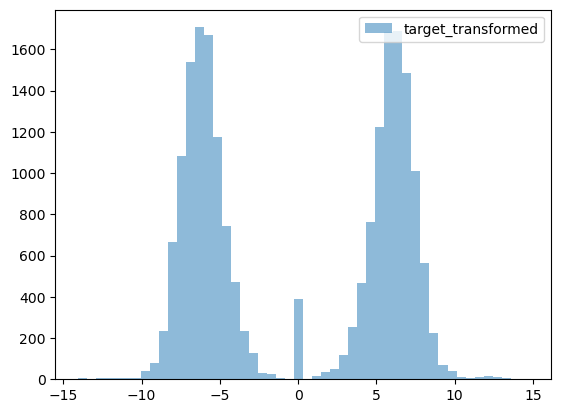

In [5]:
import matplotlib.pyplot as plt

plt.hist(df_training['target_transformed'], bins=50, alpha=0.5, label='target_transformed')
plt.legend()
plt.show()

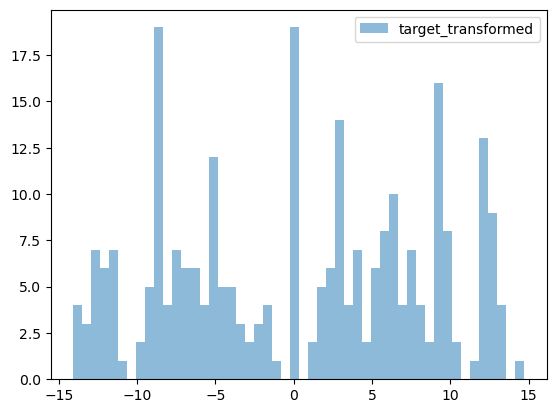

In [12]:
import pandas as pd

# Binarização
num_bins = 10
df_training['bin'] = pd.cut(df_training['target_transformed'], bins=num_bins)

# Frequência por bin
frequencia = df_training['bin'].value_counts().sort_index()

# Tamanho mínimo de amostra por bin
min_freq = frequencia.min()
# Subamostragem
def subamostrar_bin(df, bin_categoria, tamanho):
    return df[df['bin'] == bin_categoria].sample(n=tamanho, random_state=42)

df_uniforme = pd.concat([
    subamostrar_bin(df_training, bin_cat, min_freq) 
    for bin_cat in frequencia.index
])

df_uniforme = df_uniforme.reset_index(drop=True)
df_uniforme = df_uniforme.drop('bin', axis=1)

plt.hist(df_uniforme['target_transformed'], bins=50, alpha=0.5, label='target_transformed')
plt.legend()
plt.show()

In [7]:
import pandas as pd

data = {
    'target_transformed': [1]*50,
    "content1": ["A tempestade durou várias horas durante a noite.", "Ele estudou intensamente para o exame.", "A fábrica reduziu a emissão de poluentes.", "Maria começou a praticar exercícios regularmente.", "O motor do carro parou de funcionar.", "Houve uma forte seca na região.", "Ela começou a dormir melhor.", "A escola adotou uma alimentação saudável.", "O projeto teve apoio governamental.", "A internet caiu durante a reunião.", "Ele começou a economizar dinheiro mensalmente.", "A estrada estava em péssimo estado de conservação.", "O sistema de ar condicionado foi desligado no escritório.", "A empresa investiu em marketing digital.", "Ana não revisou o relatório antes de enviar.", "As crianças brincaram no parque até tarde.", "O curso de capacitação foi oferecido aos funcionários.", "Ele comprou um celular novo com câmera de alta qualidade.", "A reforma no prédio foi concluída.", "A região teve um crescimento populacional rápido.", "Carla começou a meditar diariamente.", "O atleta intensificou seu treino antes da competição.", "O sinal de celular na região foi ampliado.", "As temperaturas caíram drasticamente durante o inverno.", "Ele não configurou o alarme antes de dormir.", "A empresa ofereceu benefícios extras para seus funcionários.", "Houve um vazamento de gás na cozinha do restaurante.", "A biblioteca da escola foi modernizada com novos livros e tecnologia.", "Marcos passou a fazer pausas regulares durante o expediente.", "A empresa desenvolveu um aplicativo intuitivo para clientes.", "Devido ao aumento das chuvas nas últimas semanas, o nível dos rios subiu rapidamente e ultrapassou a capacidade das barragens.", "Ela decidiu começar uma rotina de alimentação balanceada, exercícios físicos regulares e meditação diária para melhorar sua saúde física e mental.", "A empresa, que sofria com baixos índices de produtividade, implementou uma nova estratégia de gestão focada no desenvolvimento dos funcionários e na cultura organizacional.", "O governo lançou um programa nacional de reciclagem e incentivou a participação ativa dos cidadãos por meio de campanhas de conscientização em escolas, empresas e residências.", "Após uma longa estiagem que afetou grande parte do território agrícola do país, o governo implementou um pacote emergencial de apoio aos agricultores, incluindo subsídios e incentivos para a recuperação das lavouras.", "Ele deixou o celular carregando a noite inteira sem usar carregadores de segurança e em um local sem ventilação.", "A comunidade local se uniu para limpar e revitalizar a praça abandonada, que estava sem manutenção há anos e havia se tornado um ponto de descarte irregular de lixo.", "Durante a reforma do prédio, descobriu-se que a estrutura tinha falhas graves, e o prazo para conclusão foi ampliado em seis meses para garantir a segurança.", "Um furacão atingiu a região costeira do país, com ventos de mais de 200 km/h, causando destruição em várias cidades e deixando milhares de pessoas desabrigadas.", "Ela esqueceu de regar a planta de sua varanda durante o mês todo, e o clima estava seco.", "João quebrou o braço jogando futebol.", "Devido a uma combinação de fatores climáticos extremos, incluindo ventos fortes e chuvas intensas, a região sofreu graves danos estruturais e interrupção no fornecimento de energia elétrica por vários dias.", "Ela esqueceu de levar o guarda-chuva.", "A empresa adotou práticas sustentáveis em sua produção, reduzindo o uso de plástico e implementando programas de reciclagem.", "A criança se recusou a comer legumes durante toda a semana.", "Após anos de pesquisa e desenvolvimento, a equipe científica finalmente descobriu um método eficiente para produzir energia limpa a partir de fontes renováveis.", "O café da manhã foi esquecido.", "A iniciativa comunitária organizou mutirões de limpeza nas praias locais regularmente durante o verão.", "Ele atualizou seu currículo e participou de várias entrevistas de emprego nos últimos meses.", "O artista decidiu experimentar novas técnicas em suas pinturas, incorporando elementos digitais e materiais reciclados em suas obras."],
    "content2": ["Pela manhã, muitas ruas estavam alagadas.", "Conseguiu uma nota alta na prova.", "A qualidade do ar na cidade melhorou.", "Ela perdeu peso e aumentou sua energia.", "Ele teve que chamar o guincho para levar o carro à oficina.", "As plantações foram prejudicadas, e a colheita foi menor.", "Sua disposição durante o dia melhorou significativamente.", "Os alunos passaram a ter mais energia e melhor concentração.", "Conseguiu concluir as fases iniciais rapidamente.", "A comunicação com a equipe foi interrompida.", "Conseguiu juntar uma quantia para uma viagem.", "O trânsito ficou mais lento e perigoso para os motoristas.", "O ambiente ficou quente e desconfortável para os funcionários.", "As vendas aumentaram significativamente.", "O documento continha erros e precisou ser corrigido.", "Elas ficaram cansadas e dormiram rapidamente ao chegar em casa.", "Eles melhoraram suas habilidades e eficiência no trabalho.", "Passou a tirar fotos mais nítidas e de melhor resolução.", "O local ficou mais seguro e esteticamente agradável.", "A demanda por moradias e serviços aumentou consideravelmente.", "Ela sentiu uma melhora no seu foco e redução do estresse.", "Teve um melhor desempenho e conquistou o primeiro lugar.", "A conexão ficou mais estável e acessível para os moradores.", "A procura por agasalhos e cobertores aumentou nas lojas.", "Acabou se atrasando para o trabalho na manhã seguinte.", "A satisfação e motivação dos colaboradores aumentaram.", "O local foi evacuado por segurança, e o serviço foi interrompido temporariamente.", "Os alunos começaram a frequentá-la mais e a melhorar seu desempenho acadêmico.", "Ele se sentiu mais produtivo e menos cansado ao final do dia.", "O número de usuários aumentou rapidamente.", "Diversas áreas urbanas e rurais foram afetadas por inundações, forçando muitas famílias a deixarem suas casas temporariamente.", "Em poucos meses, notou uma grande melhora em sua disposição, concentração e níveis de energia, além de perder peso.", "Em menos de um ano, a moral da equipe melhorou, a rotatividade diminuiu, e a produtividade geral aumentou em cerca de 30%.", "Como resultado, houve uma redução significativa na quantidade de resíduos sólidos em aterros e uma maior economia de recursos naturais.", "Em um ano, a produção agrícola voltou a níveis estáveis, e o impacto econômico negativo foi mitigado, beneficiando a população.", "Pela manhã, o dispositivo estava superaquecido e apresentou danos permanentes na bateria, reduzindo sua capacidade de funcionamento.", "Com a revitalização, a praça voltou a ser um local de encontro para moradores, e a segurança da área também melhorou.", "Apesar do atraso, a reforma resultou em um edifício mais seguro, confortável e com um aumento significativo no valor do imóvel.", "A resposta emergencial foi mobilizada rapidamente, com abrigos temporários e ajuda humanitária distribuída para minimizar o impacto nas vítimas.", "A planta murchou completamente e, infelizmente, não conseguiu ser recuperada, tendo que ser substituída.", "Ele ficou impossibilitado de trabalhar por duas semanas.", "A comunidade teve que recorrer a abrigos temporários, e a economia local sofreu uma queda significativa devido à paralisação das atividades comerciais.", "Ficou molhada durante o trajeto para o trabalho.", "A reputação da empresa melhorou, atraindo consumidores conscientes e aumentando as vendas em 20%.", "Sua mãe ficou preocupada com a falta de nutrientes na alimentação dele e decidiu consultar um nutricionista.", "Isso resultou na redução significativa das emissões de carbono e no avanço tecnológico sustentável, beneficiando o meio ambiente globalmente.", "Ela sentiu fome e falta de energia durante a manhã de trabalho.", "As praias ficaram mais limpas e atraentes para turistas, além de promover a conscientização ambiental entre os moradores.", "Finalmente recebeu uma oferta de trabalho em uma empresa renomada, melhorando sua estabilidade financeira.", "Suas peças ganharam destaque em exposições internacionais, ampliando seu reconhecimento e alcance no mercado de arte."]
}

# Crie o DataFrame
df_validation = pd.DataFrame(data)

# Adicionar novas frases com a ordem contrária e target 0
df_reversed = pd.DataFrame({
    'target_transformed': [-1] * len(data['target_transformed']),
    'content1': df_validation['content2'],
    'content2': df_validation['content1']
})

# Concatenar os dois DataFrames
df_validation = pd.concat([df_validation, df_reversed], ignore_index=True)

df_validation

,target_transformed,content1,content2
0,1,A tempestade durou várias horas durante a noite.,"Pela manhã, muitas ruas estavam alagadas."
1,1,Ele estudou intensamente para o exame.,Conseguiu uma nota alta na prova.
2,1,A fábrica reduziu a emissão de poluentes.,A qualidade do ar na cidade melhorou.
3,1,Maria começou a praticar exercícios regularmente.,Ela perdeu peso e aumentou sua energia.
4,1,O motor do carro parou de funcionar.,Ele teve que chamar o guincho para levar o car...
...,...,...,...
95,-1,Isso resultou na redução significativa das emi...,"Após anos de pesquisa e desenvolvimento, a equ..."
96,-1,Ela sentiu fome e falta de energia durante a m...,O café da manhã foi esquecido.
97,-1,As praias ficaram mais limpas e atraentes para...,A iniciativa comunitária organizou mutirões de...
98,-1,Finalmente recebeu uma oferta de trabalho em u...,Ele atualizou seu currículo e participou de vá...


In [8]:
# Função para o collate_fn, necessária para lidar com sequências de tamanhos variáveis
def collate_fn(batch):
    sequences1, sequences2, targets = zip(*batch)
    return sequences1, sequences2, torch.stack(targets)

In [9]:
#training_dataset = SequenceDataset()
validation_dataset = SequenceDataset_val(df_validation)

# Criar DataLoaders
"""train_dataloader = DataLoader(
  	training_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)
"""

training_dataset = InfiniteSequenceDataset(db1_path, db2_path, alias_db2)
train_dataloader = DataLoader(training_dataset, batch_size=32, num_workers=4)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

In [10]:
import torch
import torch.nn as nn


class RegressionRNN(nn.Module):
    def __init__(self, input_size=2048, hidden_size=256, num_layers=3):
        super(RegressionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True  # Configurado como True permanentemente

        # Define os RNNs para as duas sequências com bidirecionalidade
        self.rnn1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=0.3
        )

        self.rnn2 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=0.3
        )

        # Cada RNN bidirecional produz hidden_size * 2
        # Como temos duas sequências, o tamanho final é hidden_size * 4
        final_hidden_size = hidden_size * 4  # (hidden_size * 2) * 2

        # Primeira camada totalmente conectada
        self.fc1 = nn.Linear(final_hidden_size, 64)
        self.relu = nn.ReLU()

        # Segunda camada totalmente conectada para a saída
        self.fc2 = nn.Linear(64, 1)

    def _process_sequences(self, sequences, rnn):
        """
        Função auxiliar para processar uma lista de sequências através de um RNN.

        Args:
            sequences (list of tensors): Lista de tensores de entrada com tamanhos variados.
            rnn (nn.LSTM): RNN a ser usado para processar as sequências.

        Returns:
            Tensor: Estado oculto concatenado de todas as sequências no batch.
        """
        # Calcula os comprimentos das sequências
        lengths = torch.tensor(
            [seq.size(0) for seq in sequences], dtype=torch.long, device=sequences[0].device)

        # Padroniza as sequências para o mesmo comprimento
        padded_sequences = nn.utils.rnn.pad_sequence(
            sequences, batch_first=True)

        # Empacota as sequências padronizadas
        packed_input = nn.utils.rnn.pack_padded_sequence(
            padded_sequences,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Passa pelas camadas RNN
        packed_output, (h_n, _) = rnn(packed_input)

        # h_n tem a forma (num_layers * num_directions, batch, hidden_size)
        # Para bidirectional=True, num_directions = 2
        # Extraímos os estados ocultos das últimas camadas forward e backward
        # Última camada forward: forma (batch, hidden_size)
        h_n_forward = h_n[-2, :, :]
        # Última camada backward: forma (batch, hidden_size)
        h_n_backward = h_n[-1, :, :]

        # Concatena os estados ocultos forward e backward
        # forma: (batch, hidden_size * 2)
        combined = torch.cat((h_n_forward, h_n_backward), dim=1)

        return combined

    def forward(self, sequences1, sequences2):
        """
        Forward pass do modelo.

        Args:
            sequences1 (list of tensors): Primeira lista de sequências de entrada.
            sequences2 (list of tensors): Segunda lista de sequências de entrada.

        Returns:
            Tensor: Saída de regressão para cada par de sequências.
        """
        # Processa ambas as sequências usando a função auxiliar
        last_output1 = self._process_sequences(
            sequences1, self.rnn1)  # Forma: (batch, hidden_size * 2)
        last_output2 = self._process_sequences(
            sequences2, self.rnn2)  # Forma: (batch, hidden_size * 2)

        # Concatena as saídas das duas sequências
        # Forma: (batch, hidden_size * 4)
        combined_output = torch.cat((last_output1, last_output2), dim=1)

        # Passa pela primeira camada totalmente conectada
        out = self.fc1(combined_output)
        out = self.relu(out)

        # Passa pela segunda camada totalmente conectada
        out = self.fc2(out)

        return out.squeeze(1)  # Forma: (batch,)

In [11]:
# Inicializa o modelo, critério de perda e otimizador
model_order = RegressionRNN().to('cuda')
#criterion = nn.MSELoss()
criterion = nn.HuberLoss()

In [12]:
optimizer = torch.optim.Adam(
    model_order.parameters(), lr=1e-3, weight_decay=1e-6)

# Inicializar o scheduler ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, verbose=True
)

In [13]:
# Inicializar o contador de passos
step = 0

In [14]:
num_epochs = 250

In [ ]:
from torch.utils.tensorboard import SummaryWriter

2024-11-20 22:57:37.301882: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 22:57:40.818833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732154261.519002   14495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732154262.222839   14495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 22:57:45.506666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Inicializar o writer do TensorBoard
writer = SummaryWriter('runs/treinamento_regressao_rnn')

# Envolver o loop de épocas com tqdm para mostrar o progresso das épocas
epoch_progress = tqdm(range(num_epochs), desc='Treinamento', unit='época')

for epoch in epoch_progress:
    epoch_progress.set_description(f'Época {epoch+1}/{num_epochs}')

    # Treinamento
    model_order.train()
    train_loss = 0.0

    for sequences1_batch, sequences2_batch, targets_batch in train_dataloader:
        # Mover as sequências para a GPU sem empilhar
        sequences1_batch = [s.to('cuda') for s in sequences1_batch]
        sequences2_batch = [s.to('cuda') for s in sequences2_batch]
        # Alvos já estão empilhados e devem ser movidos para a GPU
        targets_batch = targets_batch.to('cuda')

        optimizer.zero_grad()

        # Forward pass
        outputs = model_order(sequences1_batch, sequences2_batch)
        loss = criterion(outputs, targets_batch)

        # Backward pass e otimização
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * targets_batch.size(0)

        # Registrar a perda de treinamento a cada passo
        writer.add_scalar('Perda_Treinamento_Passo', loss.item(), step)
        step += 1

    avg_train_loss = train_loss / len(train_dataloader.dataset)

    # Validação
    model_order.eval()
    validation_loss = 0.0
    correct_sign = 0
    total = 0

    with torch.no_grad():
        for sequences1_batch, sequences2_batch, targets_batch in validation_dataloader:
            # Mover as sequências para a GPU sem empilhar
            sequences1_batch = [s.to('cuda') for s in sequences1_batch]
            sequences2_batch = [s.to('cuda') for s in sequences2_batch]
            # Alvos já estão empilhados e devem ser movidos para a GPU
            targets_batch = targets_batch.to('cuda')

            # Forward pass
            outputs = model_order(sequences1_batch, sequences2_batch)
            loss = criterion(outputs, targets_batch)
            validation_loss += loss.item() * targets_batch.size(0)

            # Considerar apenas os alvos positivos ou negativos
            non_zero_mask = targets_batch != 0
            if non_zero_mask.sum().item() == 0:
                continue  # Pular se não houver alvos diferentes de zero

            predicted_sign = torch.sign(outputs)[non_zero_mask]
            target_sign = torch.sign(targets_batch)[non_zero_mask]

            # Calcular acertos onde os sinais correspondem
            correct_sign += (predicted_sign == target_sign).sum().item()
            total += non_zero_mask.sum().item()

    # Evitar divisão por zero
    if total > 0:
        sign_accuracy = correct_sign / total
    else:
        sign_accuracy = 0.0

    avg_validation_loss = validation_loss / len(validation_dataloader.dataset)

    # Registrar as métricas de validação por época
    writer.add_scalar('Perda_Validação_Epoca', avg_validation_loss, epoch+1)
    writer.add_scalar('Acurácia_Sinal_Validação', sign_accuracy, epoch+1)

    # Passar a perda de validação para o scheduler
    scheduler.step(avg_validation_loss)

    # Registrar a taxa de aprendizado atual (opcional)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Taxa_Aprendizado', current_lr, epoch+1)

    # Atualizar a descrição da barra com as perdas atuais e acurácia do sinal
    epoch_progress.set_postfix({
        'Perda Treinamento': f'{avg_train_loss:.3f}',
        'Perda Validação': f'{avg_validation_loss:.3f}',
        'Acurácia Sinal': f'{sign_accuracy*100:.2f}%',
        'LR': f'{current_lr:.8f}'
    })

    # Liberar cache da GPU após cada época
    torch.cuda.empty_cache()

# Fechar o SummaryWriter ao final do treinamento
writer.close()

In [ ]:
import os

# Diretório onde os modelos serão salvos
save_dir = './saved_fineweb'
os.makedirs(save_dir, exist_ok=True)

# Salvando o estado do modelo
model_path = os.path.join(save_dir, 'regression_rnn_model.pth')
torch.save(model_order.state_dict(), model_path)
print(f"Modelo salvo em {model_path}")

# Opcional: Salvando o estado do otimizador
optimizer_path = os.path.join(save_dir, 'optimizer_state.pth')
torch.save(optimizer.state_dict(), optimizer_path)
print(f"Estado do otimizador salvo em {optimizer_path}")

# Opcional: Salvar a época atual para retomar o treinamento
epoch_path = os.path.join(save_dir, 'last_epoch.pth')
torch.save({'epoch': epoch, 'model_state_dict': model_order.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_validation_loss}, epoch_path)
print(f"Checkpoint salvo em {epoch_path}")

Modelo salvo em ./saved_fineweb/regression_rnn_model.pth
Estado do otimizador salvo em ./saved_fineweb/optimizer_state.pth
Checkpoint salvo em ./saved_fineweb/last_epoch.pth


In [19]:
import os
model_path = os.path.join('./saved_fineweb', 'regression_rnn_model.pth')

# Carregar o estado do modelo
model_order.load_state_dict(torch.load(model_path, map_location='cuda'))

# Colocar o modelo em modo de avaliação
model_order.eval()

/tmp/ipykernel_386141/3511341442.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_order.load_state_dict(torch.load(model_path, map_location='cuda'))


RegressionRNN(
  (rnn1): LSTM(2048, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (rnn2): LSTM(2048, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
model_order.eval()

sequences1 = [text_to_embedding(text).to('cuda') for text in df_validation['content1']]
sequences2 = [text_to_embedding(text).to('cuda') for text in df_validation['content2']]

# Realizar a previsão
with torch.no_grad():
    output = model_order(sequences1, sequences2)

# Imprimir os resultados da previsão
for i, pred in enumerate(output):
    print(f"Resultado da previsão para o par {i+1}: {pred.item()}")

Resultado da previsão para o par 1: -0.030401533469557762
Resultado da previsão para o par 2: -0.030401533469557762
Resultado da previsão para o par 3: -0.030401533469557762
Resultado da previsão para o par 4: -0.030401533469557762
Resultado da previsão para o par 5: -0.030401533469557762
Resultado da previsão para o par 6: -0.030401533469557762
Resultado da previsão para o par 7: -0.030401533469557762
Resultado da previsão para o par 8: -0.030401533469557762
Resultado da previsão para o par 9: -0.030401533469557762
Resultado da previsão para o par 10: -0.030401533469557762
Resultado da previsão para o par 11: -0.030401533469557762
Resultado da previsão para o par 12: -0.030401533469557762
Resultado da previsão para o par 13: -0.030401533469557762
Resultado da previsão para o par 14: -0.030401533469557762
Resultado da previsão para o par 15: -0.030401533469557762
Resultado da previsão para o par 16: -0.030401533469557762
Resultado da previsão para o par 17: -0.030401533469557762
Result

In [21]:
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

with torch.no_grad():
    for example in eval_dataset:
        sent1 = example['sentence1']
        sent2 = example['sentence2']
        score = example['score']

        # Gerar embeddings para ambas as sentenças
        embedding1 = text_to_embedding(sent1).to('cuda')
        embedding2 = text_to_embedding(sent2).to('cuda')

        # Obter a previsão do modelo
        prediction = model_order([embedding1], [embedding2])
        pred_score = 1 / (1 + abs(prediction.item()))

        # Armazenar as pontuações
        true_scores.append(score)
        pred_scores.append(pred_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print("Similaridade Inversa da Diferença Absoluta")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

Similaridade Inversa da Diferença Absoluta
Correlação de Pearson: nan
Correlação de Spearman: nan


/tmp/ipykernel_22901/1158226715.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(true_scores, pred_scores)
/tmp/ipykernel_22901/1158226715.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(true_scores, pred_scores)


In [ ]:
import torch
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm  # Para acompanhar o progresso

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Definir o intervalo de valores de k a serem testados
k_values = np.arange(0.001, 100.0, 0.01)
best_k = None
best_pearson = -1  # Inicialização com um valor baixo
best_spearman = -1

# Pré-computar todas as predições para evitar recalcular múltiplas vezes
true_scores = []
predictions = []

with torch.no_grad():
    for example in tqdm(eval_dataset, desc="Processando exemplos"):
        sent1 = example['sentence1']
        sent2 = example['sentence2']
        score = example['score']

        # Gerar embeddings para ambas as sentenças
        embedding1 = text_to_embedding(sent1).to('cuda')
        embedding2 = text_to_embedding(sent2).to('cuda')

        # Obter a previsão do modelo
        prediction = model_order([embedding1], [embedding2])
        predictions.append(prediction.item())

        # Armazenar as pontuações reais
        true_scores.append(score)

true_scores = np.array(true_scores)
predictions = np.array(predictions)

# Iterar sobre os valores de k para encontrar o melhor
for k in tqdm(k_values, desc="Buscando o melhor k"):
    pred_scores = np.exp(-k * np.abs(predictions))
    
    pearson_corr, _ = pearsonr(true_scores, pred_scores)
    spearman_corr, _ = spearmanr(true_scores, pred_scores)
    
    # Verificar se este k é o melhor até agora
    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        best_spearman = spearman_corr
        best_k = k

print("Similaridade Baseada em Exponencial")
print(f"Melhor valor de k: {best_k}")
print(f"Correlação de Pearson: {best_pearson:.4f}")
print(f"Correlação de Spearman: {best_spearman:.4f}")

Buscando o melhor k: 100%|██████████| 9990/9990 [00:14<00:00, 713.55it/s]

Similaridade Baseada em Exponencial
Melhor valor de k: 0.2799999999999999
Correlação de Pearson: 0.0355
Correlação de Spearman: 0.0303


In [23]:
import os
import torch
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Verificar se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Carregar o modelo SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2").to(device)

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

# Obter as sentenças e os escores do conjunto de dados
sentences1 = eval_dataset['sentence1']
sentences2 = eval_dataset['sentence2']
scores = eval_dataset['score']

# Processar uma frase por vez
for i in range(len(eval_dataset)):
    sentence1 = sentences1[i]
    sentence2 = sentences2[i]
    true_score = scores[i]

    # Gerar embeddings para ambas as sentenças individualmente
    embedding1 = model.encode(sentence1, convert_to_tensor=True, device=device, show_progress_bar=False)
    embedding2 = model.encode(sentence2, convert_to_tensor=True, device=device, show_progress_bar=False)

    # Calcular a similaridade cosseno
    cosine_score = util.cos_sim(embedding1, embedding2).item()

    # Escalar a similaridade cosseno de [-1, 1] para [0, 1]
    scaled_score = (cosine_score + 1) / 2

    # Armazenar as pontuações
    true_scores.append(true_score)
    pred_scores.append(scaled_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

Correlação de Pearson: 0.8806
Correlação de Spearman: 0.8810


In [24]:
import os
model_path = os.path.join('./saved_HuberLoss', 'regression_rnn_model.pth')

# Carregar o estado do modelo
#model_order.load_state_dict(torch.load(model_path, map_location='cuda'))

# Colocar o modelo em modo de avaliação
model_order.eval()

# Realizar a previsão
with torch.no_grad():
    output = model_order(
        [text_to_embedding(
            "O aluno estudou para o exame durante a noite.").to('cuda')],
        [text_to_embedding("O resultado foi excelente devido à dedicação.").to('cuda')])

# Imprimir a saída da regressão
print("Resultado da previsão:", output.item())

AttributeError: 'SentenceTransformer' object has no attribute 'model'

In [ ]:
del model_order  # Remove a referência ao modelo

# Libera a memória da GPU, se o modelo estiver usando CUDA
torch.cuda.empty_cache()

# Força a coleta de lixo
gc.collect()

2203